# K-Nearest Neighbors (KNN)

We will discuss how to build K-Nearest Neighbors (KNN) model from scratch or both classification and regression task.

# Required Libraries

In [4]:
import matplotlib.pyplot as plt
import numpy as np

## Distance Calculation
Here we are going to use the Euclidean Distance i.e
$$
   d(\mathbf{x}_i, \mathbf{x}_j) = \sqrt{\sum_{k=1}^{d} (x_{i,k} - x_{j,k})^2}
$$

### Method 1: Two Loops (Brute Force)

In [5]:
def euclidean_distance_two_loops(X_train,X_test):
    """
    Compute Euclidean distance between each test point and each training point using two loops.

    Args:
        X_train (np.ndarray): Training data of shape (n_train, d)
        X_test (np.ndarray): Test data of shape (n_test, d)

    Returns:
        np.ndarray: Distance matrix of shape (n_test, n_train),
                    where entry (i, j) is the distance between X_test[i] and X_train[j]
    """
    n_test = X_test.shape[0]
    n_train = X_train.shape[0]
    dists = np.zeros((n_test, n_train))

    for i in range(n_test):
        for j in range(n_train):
            # Compute Euclidean distance between one test and one train point
            dists[i, j] = np.sqrt(np.sum((X_test[i] - X_train[j]) ** 2))

    return dists


### Method 2: One Loop (Semi-Vectorized)

In [6]:
def euclidean_distance_one_loop(X_train,X_test):
    """
    Compute Euclidean distance between each test point and all training points using one loop.

    Args:
        X_train (np.ndarray): Training data of shape (n_train, d)
        X_test (np.ndarray): Test data of shape (n_test, d)

    Returns:
        np.ndarray: Distance matrix of shape (n_test, n_train),
                    where entry (i, j) is the distance between X_test[i] and X_train[j]
    """
    n_test = X_test.shape[0]
    n_train = X_train.shape[0]
    dists = np.zeros((n_test, n_train))

    for i in range(n_test):
        # Vectorized distance to all training points for test point i
        diff = X_train - X_test[i]  # shape: (n_train, d)
        dists[i, :] = np.sqrt(np.sum(diff ** 2, axis=1))  # shape: (n_train,)

    return dists


### Method 3: Vectorized (No Loops)
This method is the most efficient and uses linear algebra:

$$
\|x - y\|^2 = \|x\|^2 + \|y\|^2 - 2x^\top y
$$

In [7]:
def euclidean_distance_vectorized(X_train,X_test):
    """
    Compute Euclidean distance between each test point and each training point using vectorized operations.

    Uses the identity: ||x - y||^2 = ||x||^2 + ||y||^2 - 2xᵀy

    Args:
        X_train (np.ndarray): Training data of shape (n_train, d)
        X_test (np.ndarray): Test data of shape (n_test, d)

    Returns:
        np.ndarray: Distance matrix of shape (n_test, n_train),
                    where entry (i, j) is the distance between X_test[i] and X_train[j]
    """
    # Squared norms of each test point, shape: (n_test, 1)
    X_test_sq = np.sum(X_test ** 2, axis=1).reshape(-1, 1)

    # Squared norms of each train point, shape: (1, n_train)
    X_train_sq = np.sum(X_train ** 2, axis=1).reshape(1, -1)

    # Cross term: -2 * x dot yᵀ, shape: (n_test, n_train)
    cross_term = -2 * np.dot(X_test, X_train.T)

    # Sum of all terms and take square root
    dists = np.sqrt(X_test_sq + X_train_sq + cross_term)

    return dists


## Model Hypothesis

Given:

* $D \in \mathbb{R}^{n_{\text{test}} \times n_{\text{train}}}$, where $D_{i,j}$ is the Euclidean distance between test point $\mathbf{x}^{(\text{test})}_i$ and training point $\mathbf{x}^{(\text{train})}_j$.
* $\mathbf{y}_{\text{train}} \in \mathbb{R}^{n_{\text{train}}}$: target labels for training points.
* $k$: number of nearest neighbors to use.


### KNN Regression Function

Predict a continuous value for each test point as the average of $k$ nearest targets.

**Step-by-step:**

1. For each test point $i$, again get:

   $$
   \mathcal{N}_k(i) = \text{argsort}(D_i)[:k]
   $$

2. Retrieve the corresponding $y$ values:

   $$
   \{ y_j : j \in \mathcal{N}_k(i) \}
   $$

3. Predict as:

   $$
   \hat{y}_i = \frac{1}{k} \sum_{j \in \mathcal{N}_k(i)} y_{{train}_{j}}
   $$


In [8]:
def knn_regression_predict(dists, y_train, k):
    """
    Predict continuous values for test samples using K-Nearest Neighbors (regression).

    Args:
        dists (np.ndarray): Distance matrix of shape (n_test, n_train), 
                            where dists[i, j] is the distance between test i and train j.
        y_train (np.ndarray): Training targets of shape (n_train,)
        k (int): Number of nearest neighbors to consider

    Returns:
        np.ndarray: Predicted regression values for each test sample, shape (n_test,)
    """
    n_test = dists.shape[0]
    y_pred = np.zeros((n_test,1), dtype=float)

    for i in range(n_test):
        # Get indices of k nearest neighbors
        neighbors_idx = np.argsort(dists[i])[:k]

        # Extract corresponding values and take mean
        neighbor_values = y_train[neighbors_idx]
        y_pred[i] = np.mean(neighbor_values)

    return y_pred


### KNN Classification

Predict class label for each test point using majority voting among $k$ closest training points.

**Step-by-step:**

1. For each test point $i$, find indices $j_1, j_2, \dots, j_k$ of the $k$ smallest elements in row $D_i$:

   $$
   \mathcal{N}_k(i) = \text{argsort}(D_i)[:k]
   $$

2. Get labels:

   $$
   \{ y_{{train}_{j}} \mid j \in \mathcal{N}_k(i) \}
   $$

3. Predict class as the most frequent label among those $k$ labels:

   $$
   \hat{y}_i = \text{mode}\left( \{ y_{{train}_{j}} : j \in \mathcal{N}_k(i) \} \right)
   $$

In [9]:
def knn_classification_predict(dists, y_train, k=3):
    """
    Predict class labels for test samples using K-Nearest Neighbors (classification)
    without using collections.Counter.

    Args:
        dists (np.ndarray): Distance matrix of shape (n_test, n_train), 
                            where dists[i, j] is the distance between test i and train j.
        y_train (np.ndarray): Training labels of shape (n_train,)
        k (int): Number of nearest neighbors to consider

    Returns:
        np.ndarray: Predicted class labels for each test sample, shape (n_test,)
    """
    n_test = dists.shape[0]
    y_pred = np.zeros((n_test,1), dtype=int)

    for i in range(n_test):
        # Get indices of the k nearest neighbors
        neighbors_idx = np.argsort(dists[i])[:k]
        
        # Get the corresponding labels
        neighbor_labels = y_train[neighbors_idx]

        # Count occurrences of each label
        unique_labels, counts = np.unique(neighbor_labels, return_counts=True)
        
        # Choose the label with the highest count (mode)
        majority_label = unique_labels[np.argmax(counts)]
        y_pred[i] = majority_label

    return y_pred

## KNN Performance Evaluation

### Regression Loss (Mean Squared Error)
$$
  \text{MSE} = \frac{1}{n_{\text{test}}} \sum_{i=1}^{n_{\text{test}}} (y_{\text{true}}^{(i)} - \hat{y}_{\text{test}}^{(i)})^2
$$

In [10]:
def knn_regression_loss_mse(y_true, y_pred):
    """
    Compute Mean Squared Error (MSE) for KNN regression.

    Args:
        y_true (np.ndarray): True continuous values of shape (n_test,)
        y_pred (np.ndarray): Predicted continuous values of shape (n_test,)

    Returns:
        float: Mean squared error
    """
    errors = y_true - y_pred
    mse = np.mean(errors ** 2)
    return mse


### Classification Accuracy And Loss (Misclassification Rate)
* **Accuracy** (as a performance measure):

  $$
  \text{Accuracy} = \frac{\text{Number of Correct Predictions}}{n_{\text{test}}}
  $$

  Where $n\_{\text{test}}$ is the number of test examples.
* **Misclassification Rate** (as the loss function):

  $$
  \text{Loss} = \frac{\text{Number of Incorrect Predictions}}{n_{\text{test}}}
  $$

In [11]:
# Accuracy
def knn_accuracy(y_true, y_pred):
    """
    Compute classification accuracy for KNN.

    Args:
        y_true (np.ndarray): True labels of shape (n_test,)
        y_pred (np.ndarray): Predicted labels of shape (n_test,)

    Returns:
        float: Accuracy score (between 0 and 1)
    """
    correct = np.sum(y_true == y_pred)
    total = len(y_true)
    return correct / total
 
# Misclassification Rate
def knn_classification_loss(y_true, y_pred):
    """
    Compute misclassification rate (i.e., classification loss).

    Args:
        y_true (np.ndarray): True labels of shape (n_test,)
        y_pred (np.ndarray): Predicted labels of shape (n_test,)

    Returns:
        float: Misclassification rate (between 0 and 1)
    """
    incorrect = np.sum(y_true != y_pred)
    total = len(y_true)
    return incorrect / total


# KNN Regression Implimentation
Here we use the regression functions created above to come up with the full knn implimentation

### Regression Synthetic Data

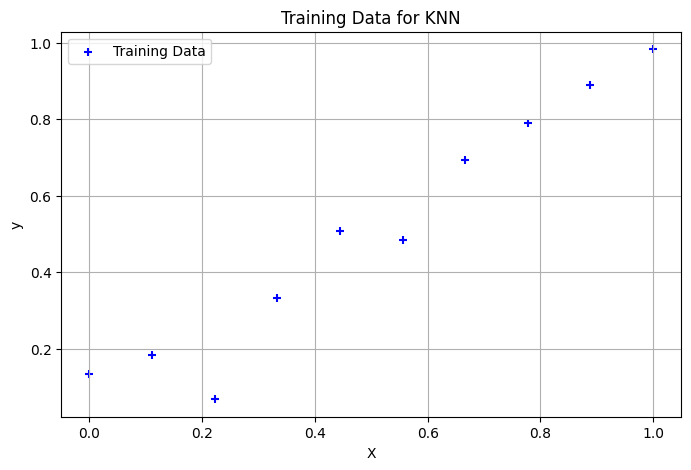

In [12]:
np.random.seed(10)
X_train = np.linspace(0, 1, 10)
y_train = X_train + np.random.normal(0, 0.1, size=(10,))
xtrain = X_train.reshape(-1, 1)
ytrain = y_train.reshape(-1, 1)

X_test = np.linspace(0, 1, 100)
xtest = X_test.reshape(-1, 1)

y_test = X_test  # No noise
ytest = y_test.reshape(-1, 1)


# Plot training data
plt.figure(figsize=(8, 5))
plt.scatter(X_train, y_train, marker="+", color='blue', label="Training Data")
plt.title("Training Data for KNN")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()


k=1, MSE=0.0059
k=2, MSE=0.0034
k=3, MSE=0.0023
k=4, MSE=0.0045
k=5, MSE=0.0102
k=6, MSE=0.0158
k=7, MSE=0.0269
k=8, MSE=0.0449
k=9, MSE=0.0634
k=10, MSE=0.0851
The best k is k= 3


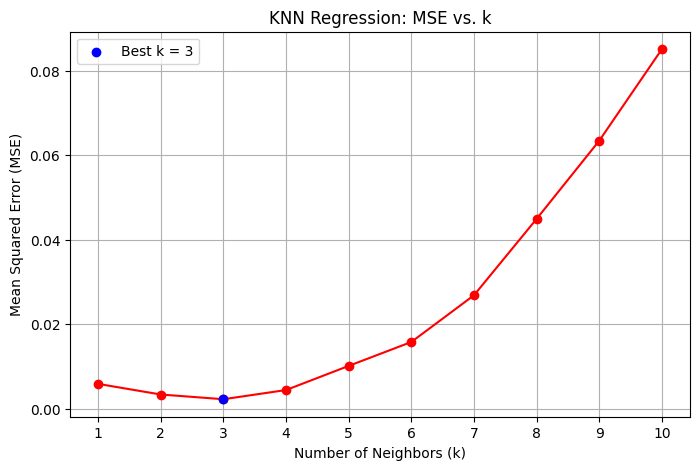

In [13]:
#Distance Matrix
dist_matrix = euclidean_distance_vectorized(xtrain,xtest)

mse_list = []
k_values = range(1, 11)

for k in k_values:
    y_pred = knn_regression_predict(dist_matrix, ytrain, k)
    mse = knn_regression_loss_mse(ytest, y_pred)
    mse_list.append(mse)
    print(f"k={k}, MSE={mse:.4f}")

print(f"The best k is k= {k_values[np.argmin(mse_list)]}")

#Plot k vs MSE
plt.figure(figsize=(8, 5))
plt.plot(k_values, mse_list, marker='o', color='red')
plt.scatter(k_values[np.argmin(mse_list)], min(mse_list), color='blue', label=f'Best k = {k_values[np.argmin(mse_list)]}', zorder=5)
plt.title("KNN Regression: MSE vs. k")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Mean Squared Error (MSE)")
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.show()


# KNN Classification Implimentation
Here we use the classification functions created above to come up with the full knn implimentation

### Classification Synthetic Data

(240, 2) (60, 2) (240, 1) (60, 1)


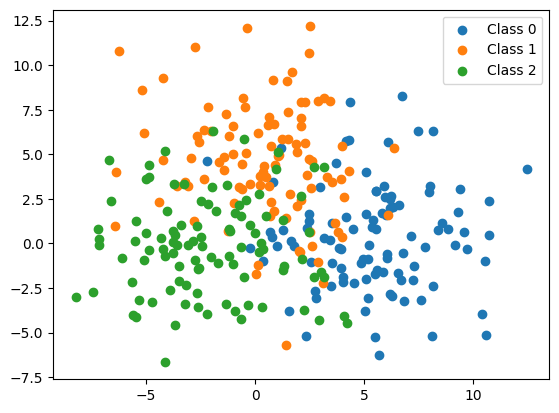

In [14]:
np.random.seed(1234)
n = 300
X1 = np.random.normal((0,5), 3, (n//3,2))
Y1 = np.ones((n//3,1))
X2 = np.random.normal((5,0), 3, (n//3,2))
Y2 = 0 * np.ones((n//3,1))
X3 = np.random.normal((-2,0), 3, (n//3,2))
Y3 = 2 * np.ones((n//3,1))

X = np.vstack([X1,X2,X3])
Y = np.vstack([Y1,Y2,Y3]).astype(int)


# shuffle data
idx = np.random.permutation(X.shape[0])
X, Y = X[idx,:], Y[idx]

# train/test split
ratio = 0.8
X_train, Y_train = X[:int (ratio*X.shape[0]), :], Y[:int (ratio*X.shape[0]), :]

X_test, Y_test = X[int (ratio*X.shape[0]):, :], Y[int (ratio*X.shape[0]):, :]

print (X_train.shape, X_test.shape , Y_train.shape, Y_test.shape)

# plot the data
labels = np.unique(Y[:, 0])
for label in labels:
    plt.scatter(X[Y[:, 0] == label, 0], X[Y[:, 0] == label, 1], label=f'Class {int(label)}')
plt.legend()
plt.show()

k=1, Loss=0.3333, Accuracy=0.6667
k=2, Loss=0.3667, Accuracy=0.6333
k=3, Loss=0.3000, Accuracy=0.7000
k=4, Loss=0.2500, Accuracy=0.7500
k=5, Loss=0.2333, Accuracy=0.7667
k=6, Loss=0.2667, Accuracy=0.7333
k=7, Loss=0.2500, Accuracy=0.7500
k=8, Loss=0.2333, Accuracy=0.7667
k=9, Loss=0.2500, Accuracy=0.7500
k=10, Loss=0.2667, Accuracy=0.7333
The best k is k= 5


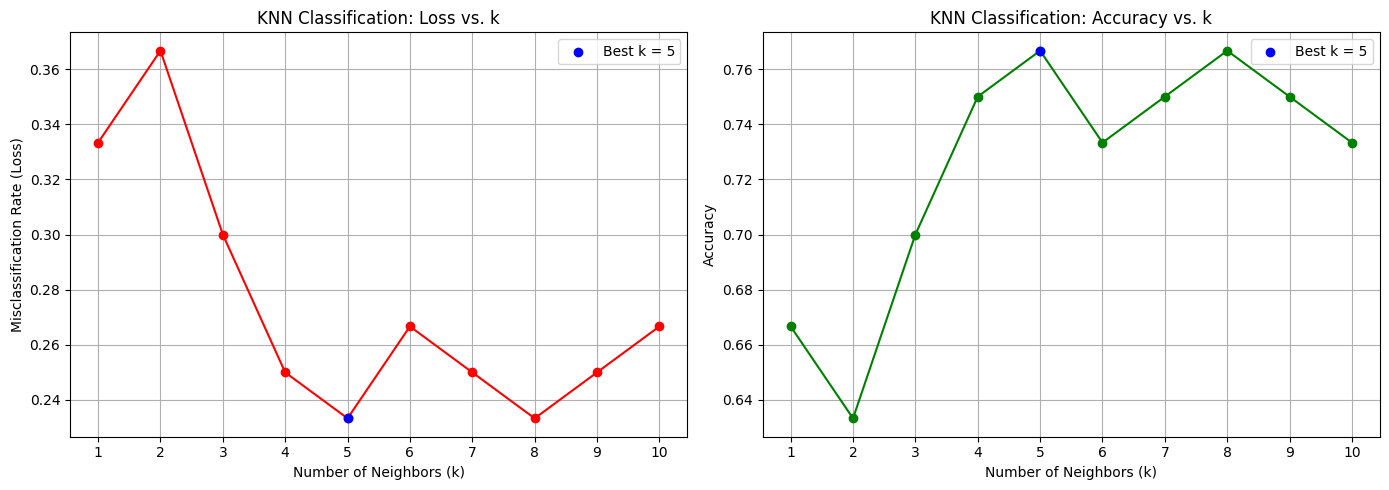

In [15]:
# Distance Matrix
dist_matrix = euclidean_distance_vectorized(X_train,X_test)

loss_list = []
accuracy_list = []
k_values = range(1, 11)

for k in k_values:
    y_pred = knn_classification_predict(dist_matrix, Y_train, k)
    loss = knn_classification_loss(Y_test, y_pred)
    accuracy = knn_accuracy(Y_test, y_pred)
    loss_list.append(loss)
    accuracy_list.append(accuracy)
    print(f"k={k}, Loss={loss:.4f}, Accuracy={accuracy:.4f}")

print(f"The best k is k= {k_values[np.argmin(loss_list)]}")
# Plot Loss vs k
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, loss_list, marker='o', color='red')
plt.scatter(k_values[np.argmin(loss_list)], min(loss_list), color='blue', label=f'Best k = {k_values[np.argmin(loss_list)]}', zorder=5)
plt.title("KNN Classification: Loss vs. k")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Misclassification Rate (Loss)")
plt.xticks(k_values)
plt.grid(True)
plt.legend()


# Plot Accuracy vs k
plt.subplot(1, 2, 2)
plt.plot(k_values, accuracy_list, marker='o', color='green')
plt.scatter(k_values[np.argmax(accuracy_list)], max(accuracy_list), color='blue', label=f'Best k = {k_values[np.argmax(accuracy_list)]}', zorder=5)
plt.title("KNN Classification: Accuracy vs. k")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.xticks(k_values)
plt.grid(True)
plt.legend()


plt.tight_layout()
plt.show()



## KNN Class
Here we have combined all that we have discussed above in to a class. You can see the usage below

### 1. Classification


[Classification] Error: 0.0700
[Classification] Accuracy: 0.9300


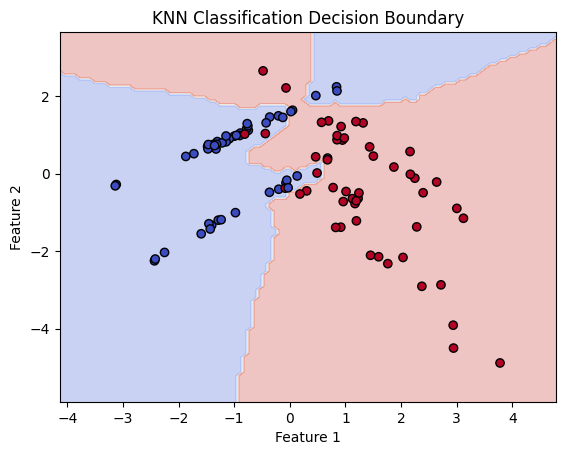

In [16]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from ek_ml_package.knn import KNNClassification
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# -------------------------------
# Classification Test
# -------------------------------
# Generate 2D classification data
X_clf, y_clf = make_classification(n_samples=500, n_features=2, n_classes=2, n_redundant=0, random_state=42)

# Train-test split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)


# Fit model
model = KNNClassification(k=5)
model.fit(X_train_clf, y_train_clf)
loss = model.loss(model.predict(X_test_clf), y_test_clf)
accuracy = model.accuracy(X_test_clf, y_test_clf)
print(f"[Classification] Error: {loss:.4f}")
print(f"[Classification] Accuracy: {accuracy:.4f}")


# Plot decision boundary
def plot_knn_decision_boundary(model, X, y, resolution=100):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                         np.linspace(y_min, y_max, resolution))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.title("KNN Classification Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

plot_knn_decision_boundary(model, X_test_clf, y_test_clf)


### 2. Regression

[Regression] MSE: 275.9408


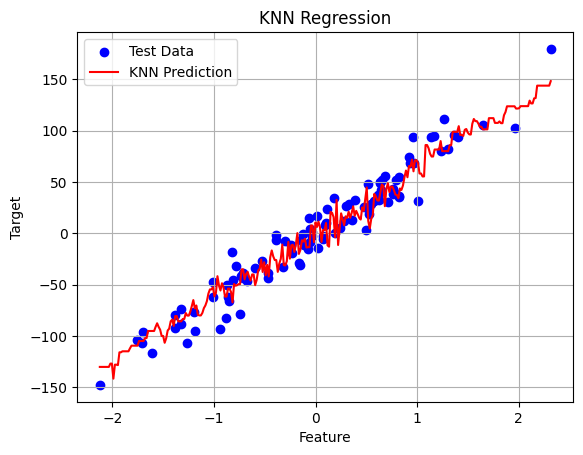

In [17]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from ek_ml_package.knn import KNNRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

# -------------------------------
# Regression Test
# -------------------------------
# Generate synthetic regression data
X_reg, y_reg = make_regression(n_samples=500, n_features=1, noise=15.0, random_state=42)

# Train-test split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)


# Initialize and fit KNN Regressor
model = KNNRegression(k=3)
model.fit(X_train_reg, y_train_reg)

# Predict on a smooth range for plotting
X_test = np.linspace(X_test_reg.min(), X_test_reg.max(), 300).reshape(-1, 1)
y_hat = model.predict(X_test)

y_pred = model.predict(X_test_reg)
mse = model.loss(y_test_reg, y_pred)
print(f"[Regression] MSE: {mse:.4f}")

# Plotting
plt.scatter(X_test_reg, y_test_reg, color='blue', label='Test Data')
plt.plot(X_test, y_hat, color='red', label='KNN Prediction')
plt.title("KNN Regression")
plt.xlabel("Feature")
plt.ylabel("Target")
plt.legend()
plt.grid(True)
plt.show()